This code was written and designed but Kuba Jerzmanowski

Code designed after "Reservoir observers: Model-free inference of unmeasured variables in chaotic systems" by: Zhixin Lu  ; Jaideep Pathak  ; Brian Hunt; Michelle Girvan; Roger Brockett; Edward Ott 

In [891]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [892]:
def rossler(x, y, z, a=0.5, b=2, c=4):
    dxdt = (-y)-z
    dydt = x + a*y
    dzdt = b + z*(x-c)
    return dxdt, dydt, dzdt

In [893]:
def lorenz(x, y, z, a=10, b=28, c=8/3):
    dxdt = -a*x + a*y
    dydt = b*x - y - x*z
    dzdt = x*y - c*z
    return dxdt, dydt, dzdt

In [894]:
def euler_method(system, init_state, dt, num_steps):
    state = np.array(init_state)
    time_series = [state]
    
    # for _ in range(num_steps):
    #     dx,dy,dz = system(*state) 
    #     state = state + np.array([[dx],[dy],[dz]]) * dt
    #     time_series.append(state)
    
    #faster if we do this
    for _ in range(num_steps):
        derv = system(*state) 
        state = state + np.array(derv) * dt
        time_series.append(state)
    
    return np.array(time_series)

In [895]:
rossler_initial = [1, 1, 1]
rossler_dt = 0.05
rossler_steps = 1000
rossler_data = euler_method(rossler, rossler_initial, rossler_dt, rossler_steps).T

# lorenz_initial = [1, 1, 1]
# lorenz_dt = 0.0001
# lorenz_steps = 1000
# I could not find good inital conditions these were found with the assistance of Claude AI
lorenz_initial = [-8, 8, 27]  
lorenz_dt = 0.01 
lorenz_steps = 1000
lorenz_data = euler_method(lorenz, lorenz_initial, lorenz_dt, lorenz_steps).T

In [896]:
print(rossler_data.shape)

(3, 1001)


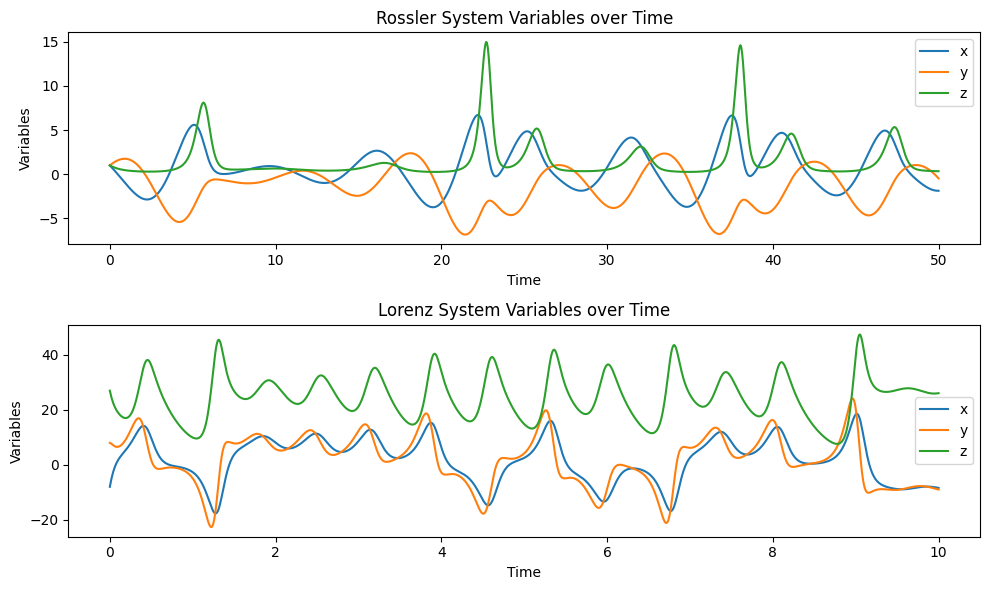

In [897]:
rossler_time = [rossler_dt * i for i in range(rossler_steps+1)]
lorenz_time = [lorenz_dt * i for i in range(lorenz_steps+1)]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(rossler_time, rossler_data[0,:], label="x")
plt.plot(rossler_time, rossler_data[1,:], label="y")
plt.plot(rossler_time, rossler_data[2,:], label="z")
plt.title("Rossler System Variables over Time")
plt.xlabel("Time")
plt.ylabel("Variables")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lorenz_time, lorenz_data[0,:], label="x")
plt.plot(lorenz_time, lorenz_data[1,:], label="y")
plt.plot(lorenz_time, lorenz_data[2,:], label="z")
plt.title("Lorenz System Variables over Time")
plt.xlabel("Time")
plt.ylabel("Variables")
plt.legend()

plt.tight_layout()
plt.show()


___


In [898]:
class ReservoirObs:
    def __init__(self, M, P, reservoir_num=400, s_r=1, avg_deg=20, scale_input_w=1, bias_const=1, leak_rate=1, noise_level=0, K=0, delta_t=1):
        self.reservoir_num = reservoir_num
        self.alpha = leak_rate
        self.bias_const = bias_const
        self.r = None
        self.M = M
        self.P = P
        self.noise_level = noise_level
        self.K = K #the num dealy K in the paper
        self.delta_t = delta_t #(d sub k) in the paper the coefficent on the delay


        self.W_in = np.random.uniform(-scale_input_w, scale_input_w, (self.reservoir_num, M)) #N is size of the 
        self.b_in = np.ones(self.reservoir_num)

        #make the reservoir matrix 
        density = avg_deg/self.reservoir_num
        A = np.random.rand(self.reservoir_num,self.reservoir_num)
        A = A * (np.zeros(A.shape) < density) #bool mask to make it sparse
        #now we need to scale so the larges abs eignval is == s_r
        eigen = np.linalg.eigvals(A)
        self.A = A * s_r/(np.max(np.abs(eigen)))

        self.W_out = None
        self.b_out = None

    def add_noise(self, data):
        return data + np.random.uniform(-self.noise_level, self.noise_level, data.shape)


    def reservoir_evolution(self, r, u):
        a1 = np.tanh(self.A @ r)
        a2 = self.W_in @ u
        return (1-self.alpha)*r + self.alpha*(a1 + a2 + self.b_in*self.bias_const)

    def train(self, U, Y, beta=0.0000001):
        U = self.add_noise(U)
        Y = self.add_noise(Y)

        U_mean = np.mean(U, axis=1, keepdims=True)
        U_variance = np.var(U, axis=1, keepdims=True)#+1e-10
        Y_mean = np.mean(Y, axis=1, keepdims=True)
        Y_variance = np.var(Y, axis=1, keepdims=True)#+1e-10
        
        normalized_U = (U - U_mean) / U_variance
        normalized_Y = (Y - Y_mean) / Y_variance

        r = np.zeros((self.reservoir_num, Y.shape[1]))
        for k in range(Y.shape[1]-1):
            r[:,k+1] = self.reservoir_evolution(r[:,k], normalized_U[:,k])

        r_mean = np.reshape(np.mean(r, axis=1), [-1,1])
        R = r-r_mean
        S = normalized_Y - np.reshape(np.mean(normalized_Y, axis=1), (-1,1))

        if self.K <= 0:     
            part1 = S @ R.T
            part2 = (R @ R.T) + beta * np.identity(self.reservoir_num)

            self.W_out = part1 @ np.linalg.inv(part2)
            self.b_out = -np.reshape((self.W_out @ r_mean) - np.reshape(np.mean(normalized_Y, axis=1), (-1,1)), (-1))

            self.r = r[:,-1]
            return U_mean, U_variance, Y_mean, Y_variance
        else:
            U_delayed = np.zeros((self.K * self.M, U.shape[1]))
            
            for k in range(self.K):
                U_delayed[k * self.M:(k + 1) * self.M, :] = np.roll(normalized_U, k * self.delta_t, axis=1)

                X = np.vstack([R, U_delayed])

                part1 = S @ X.T
                part2 = (X @ X.T) + beta * np.identity(X.shape[0])

                W_out_combined = part1 @ np.linalg.inv(part2)

                self.W_out = W_out_combined[:, :self.reservoir_num]
                self.d = W_out_combined[:, self.reservoir_num:]

                self.b_out = -np.reshape((self.W_out @ r_mean) - np.reshape(np.mean(normalized_Y, axis=1), (-1, 1)), (-1))

                self.r = r[:, -1]
                return U_mean, U_variance, Y_mean, Y_variance


    
    def predict(self, U, U_mean, U_var, Y_mean, Y_var):
        U = self.add_noise(U)
        pred = np.zeros([self.P, U.shape[1]])
        if self.K <= 0:
            for k in range(U.shape[1]):
                Y = np.reshape((self.W_out @ self.r) + self.b_out,  [-1,1])
                normalized_U = np.reshape(np.squeeze((U[:,k]-U_mean)/U_var), [-1])
                self.r = self.reservoir_evolution(self.r, normalized_U)
                pred[:,k] = np.reshape(Y*Y_var+Y_mean, [-1])
            return pred
        else:
            U_buffer = np.zeros((self.M, self.K))
            for k in range(U.shape[1]):
                normalized_U = np.reshape(np.squeeze((U[:, k] - U_mean) / U_var), [-1])
                
                U_buffer = np.roll(U_buffer, 1, axis=1)
                U_buffer[:, 0] = normalized_U

                reservoir_output = self.W_out @ self.r
                delayed_input_contribution = np.sum(self.d * U_buffer, axis=1)

                Y = reservoir_output + delayed_input_contribution + self.b_out

                self.r = self.reservoir_evolution(self.r, normalized_U)
                pred[:, k] = Y * Y_var.flatten() + Y_mean.flatten()

            return pred

In [899]:
def plot_results(true_data, predicted_data, system_name):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    for i in range(2):
        axs[i].plot(true_data[i], label='True')
        axs[i].plot(predicted_data[i], label='Predicted')
        axs[i].legend()
    
    plt.xlabel('Time step')
    plt.suptitle(f'{system_name} System: True vs Predicted')
    plt.tight_layout()
    plt.show()

____

### Lets recreate figure 2 from part A in the paper

In [900]:
# Make the data
rossler_initial = [1, 1, 1]
rossler_dt = 0.05
rossler_steps = 1000
rossler_data = euler_method(rossler, rossler_initial, rossler_dt, rossler_steps).T

print(rossler_data.shape)

(3, 1001)


We now need to pick one of the coordinates to be U the always available knowledge and the the other 2 to be the ones we deduce.

In [901]:
U = np.reshape(rossler_data[0,:],(1,-1)) #this is the continouesly avalable data. We will use the first coordinate. 
Y_ross = rossler_data[1:] #this is what we will try to deduce. the other two coordinates 

print(f'Confirm that the shapes are good: \n{U.shape}')
print(Y_ross.shape)

M = U.shape[0] 
P = Y_ross.shape[0]

rossler_obs = ReservoirObs(M=M, P=P, reservoir_num=400)
r_U_mean, r_U_var, r_Y_mean, r_Y_var = rossler_obs.train(U, Y_ross)

Confirm that the shapes are good: 
(1, 1001)
(2, 1001)


Now lets predict

(2, 1001)


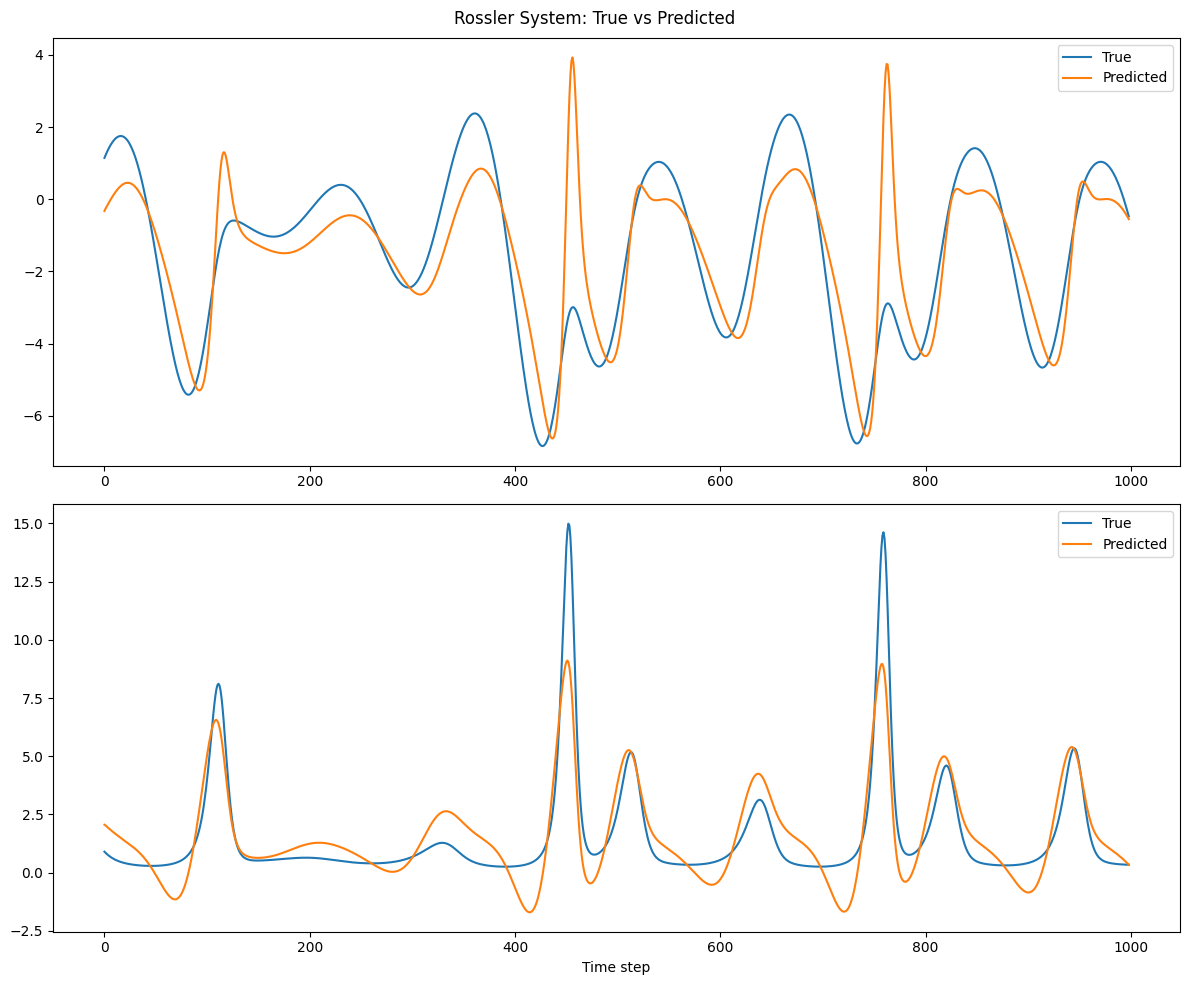

In [902]:
rossler_predictions = rossler_obs.predict(U, r_U_mean, r_U_var, r_Y_mean, r_Y_var)
print(rossler_predictions.shape)
plot_results(Y_ross[:,2:], rossler_predictions[:,2:], 'Rossler') #wwe ignore the first two points because the r needs to warm up

----

### Lets recreate figure 3 from part A in the paper

In [903]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [904]:
def test_point(param_name,value,num_models=10):
    total_rmse = 0
    for model in range(num_models):
        if param_name == 'reservoir_num':
            test_model = ReservoirObs(M=M, P=P,reservoir_num=value)
        else:
            test_model = ReservoirObs(M=M, P=P)
            setattr(test_model, param_name, value)
        r_U_mean, r_U_var, r_Y_mean, r_Y_var = test_model.train(U, Y_ross)
        rossler_predictions = test_model.predict(U, r_U_mean, r_U_var, r_Y_mean, r_Y_var)
        total_rmse += rmse(Y_ross[:,2:], rossler_predictions[:,2:])

    return (total_rmse/num_models)

        

In [905]:
def test_hyper_p(param_name, range):
    if param_name != 'reservoir_num':
        full_range = np.linspace(range[0],range[1],num=range[2])
    else:
        full_range = np.linspace(range[0],range[1],num=range[2]).astype(int)
    res = {}
    for point in full_range:
        avg_rmse = test_point(param_name, point)
        res.update({point:avg_rmse})
    return res

In [906]:
#for each hyper param we will go in the range between the first two values and then the last one is how many to sample
hyper_params = {
        'reservoir_num':[1,1000, 9],
        's_r':[0.5,1.5,10], 
        'avg_deg' :[1,1000,8], 
        'scale_input_w':[0,4,8], 
        'bias_const':[0.5,2,7], 
        'leak_rate':[0,1,10] 
}

results = []
for hyper_p in tqdm(hyper_params.keys()):
    res = test_hyper_p(hyper_p, hyper_params[hyper_p])
    results.append({hyper_p:res})

100%|██████████| 6/6 [02:05<00:00, 20.92s/it]


/var/folders/g7/qrp04c4n56q06wny0phpjyrc0000gn/T/ipykernel_18454/2714268447.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


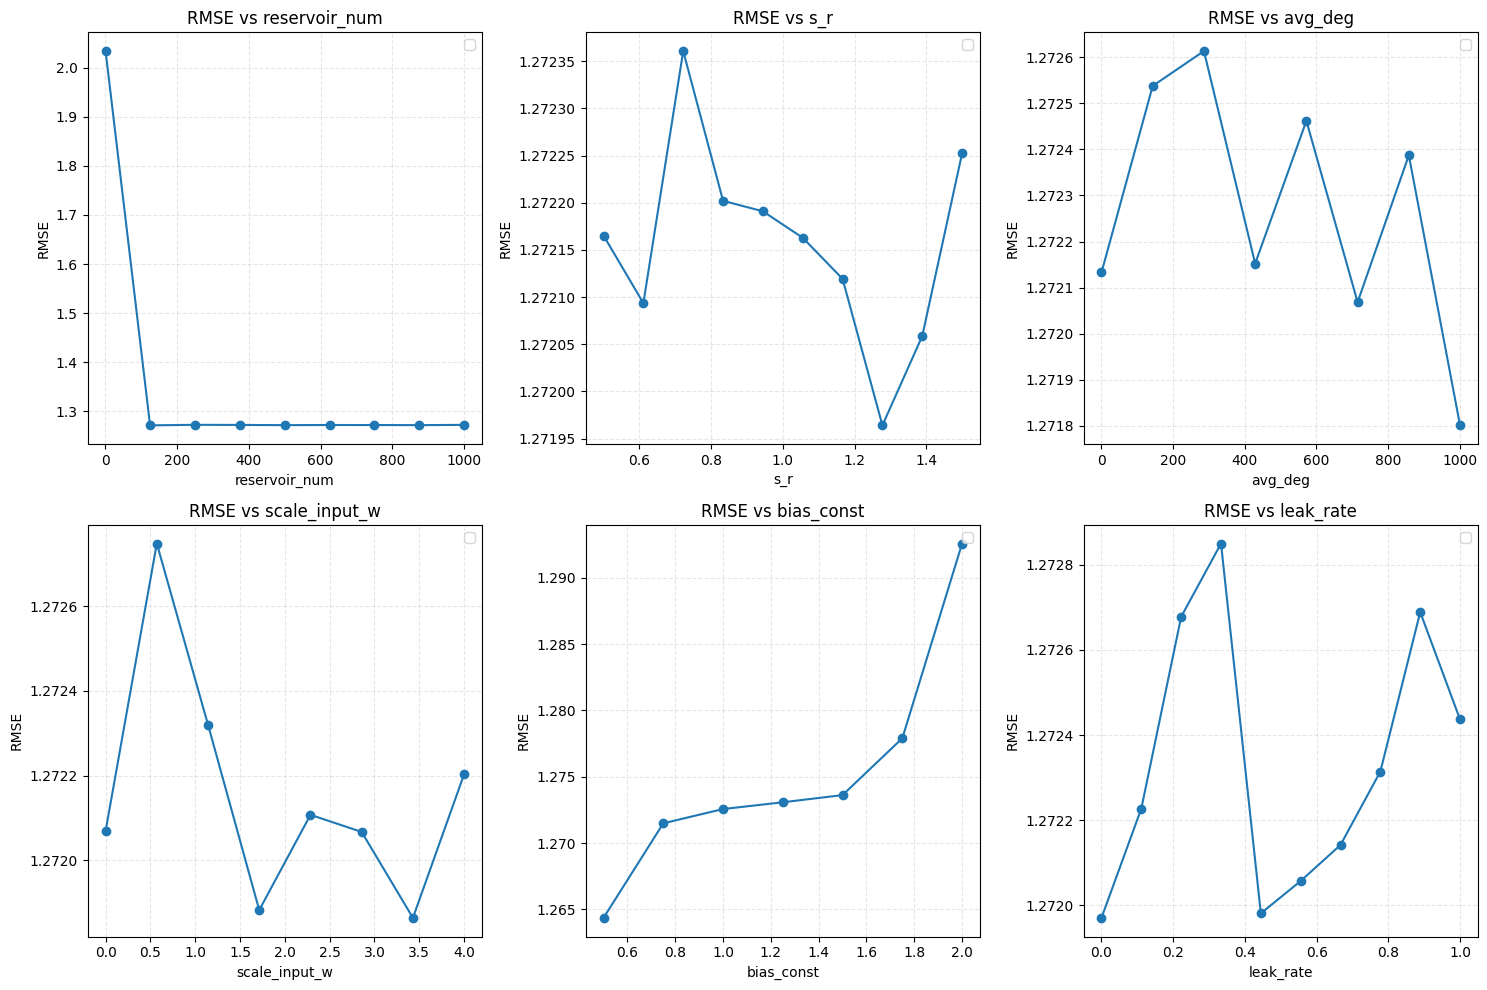

In [907]:
#ploting the results
plt.figure(figsize=(15, 10))

for i, result in enumerate(results):
    param_name = list(result.keys())[0]
    param_values, rmse_values = result[param_name].keys(), result[param_name].values()
    
    plt.subplot(2, 3, i+1)
    plt.plot(param_values, rmse_values, 'o-')
    plt.title(f'RMSE vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    
    plt.grid(True, linestyle='--', alpha=.3) #grid on plot
    
    
    plt.legend()

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

___

### Lets recreate figure 4 from part A in the paper

In [908]:
def test_point(value, with_equation):
    if not with_equation:
        test_model = ReservoirObs(M=M, P=P,reservoir_num=value)
    else:
        test_model = ReservoirObs(M=M, P=P,reservoir_num=value, K=20)
    r_U_mean, r_U_var, r_Y_mean, r_Y_var = test_model.train(U, Y_ross)
    rossler_predictions = test_model.predict(U, r_U_mean, r_U_var, r_Y_mean, r_Y_var)
    return rmse(Y_ross[:,2:], rossler_predictions[:,2:])

In [909]:
full_range = np.linspace(10,1000,num=9).astype(int)
num_models = 5
def model_test(with_equation):
    results = []
    for point in tqdm(full_range):
        model_res = 0
        for model in range(num_models):
            model_res += test_point(point, with_equation)
        results.append(model_res/num_models)
    return results

In [910]:
results_no_equation = model_test(with_equation=False)
results_with_equation = model_test(with_equation=True)

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


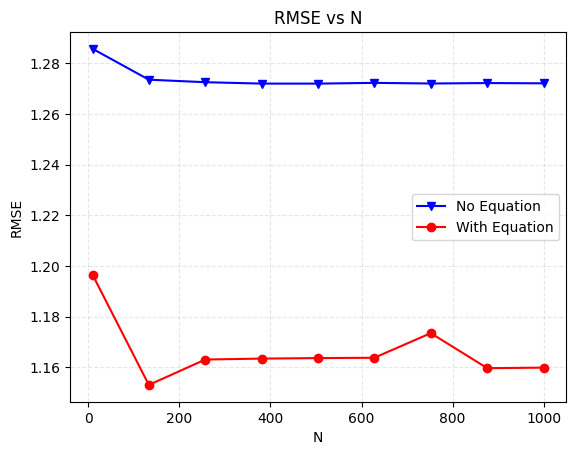

In [911]:
plt.plot(full_range, results_no_equation, color='blue', marker='v', label='No Equation')
plt.plot(full_range, results_with_equation, color='red', marker='o', label='With Equation')


plt.title(f'RMSE vs N')
plt.xlabel('N')
plt.ylabel('RMSE')

plt.grid(True, linestyle='--', alpha=.3) #grid on plot
plt.legend()

For the other part of figure 4

In [912]:
noise_levels = [10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]
errors = []
num_models = 6

for noise in noise_levels:
    error_sum = 0
    for model in range(num_models):
        noise_model = ReservoirObs(M, P, noise_level=noise)
        r_U_mean, r_U_var, r_Y_mean, r_Y_var = noise_model.train(U, Y_ross)
        rossler_predictions = noise_model.predict(U, r_U_mean, r_U_var, r_Y_mean, r_Y_var)
        error_sum += rmse(Y_ross[:,2:], rossler_predictions[:,2:])
    errors.append(error_sum/num_models)

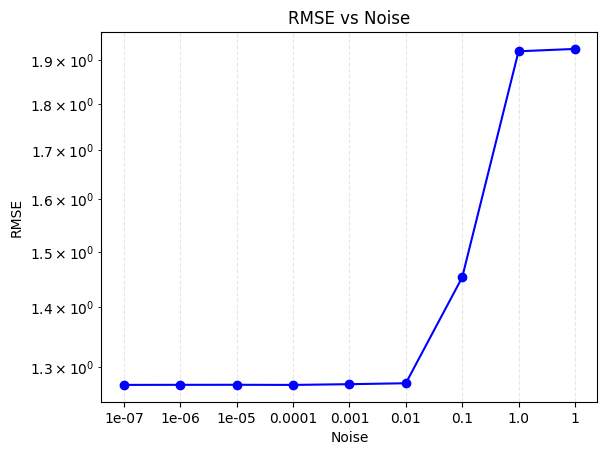

In [913]:
plt.plot(errors, color='blue', marker='o')


plt.title(f'RMSE vs Noise')
plt.xlabel('Noise')
plt.ylabel('RMSE')
plt.yscale('log')

plt.xticks(list(range(9)),noise_levels)


plt.grid(True, linestyle='--', alpha=.3) #grid on plot

___

### Lets recreate figure 5 from part B in the paper
So we use x to deduce y and z

In [914]:
# Make the data
# lorenz_initial = [1, 1, 1]
# lorenz_dt = 0.004
# lorenz_steps = 200
lorenz_initial = [-8, 8, 27] 
lorenz_dt = 0.01  
lorenz_steps = 1000
lorenz_data = euler_method(lorenz, lorenz_initial, lorenz_dt, lorenz_steps).T

print(rossler_data.shape)


U = np.reshape(lorenz_data[0,:],(1,-1)) #this is the continouesly avalable data. We will use the first coordinate. 
Y_lor = lorenz_data[1:] #this is what we will try to deduce. the other two coordinates 

print(f'Confirm that the shapes are good: \n{U.shape}')
print(Y_lor.shape)

M = U.shape[0] 
P = Y_lor.shape[0]

lorenz_obs = ReservoirObs(M=M, P=P, reservoir_num=400)
l_U_mean, l_U_val, l_Y_mean, l_Y_var = lorenz_obs.train(U, Y_lor)

(3, 1001)
Confirm that the shapes are good: 
(1, 1001)
(2, 1001)


(2, 1001)


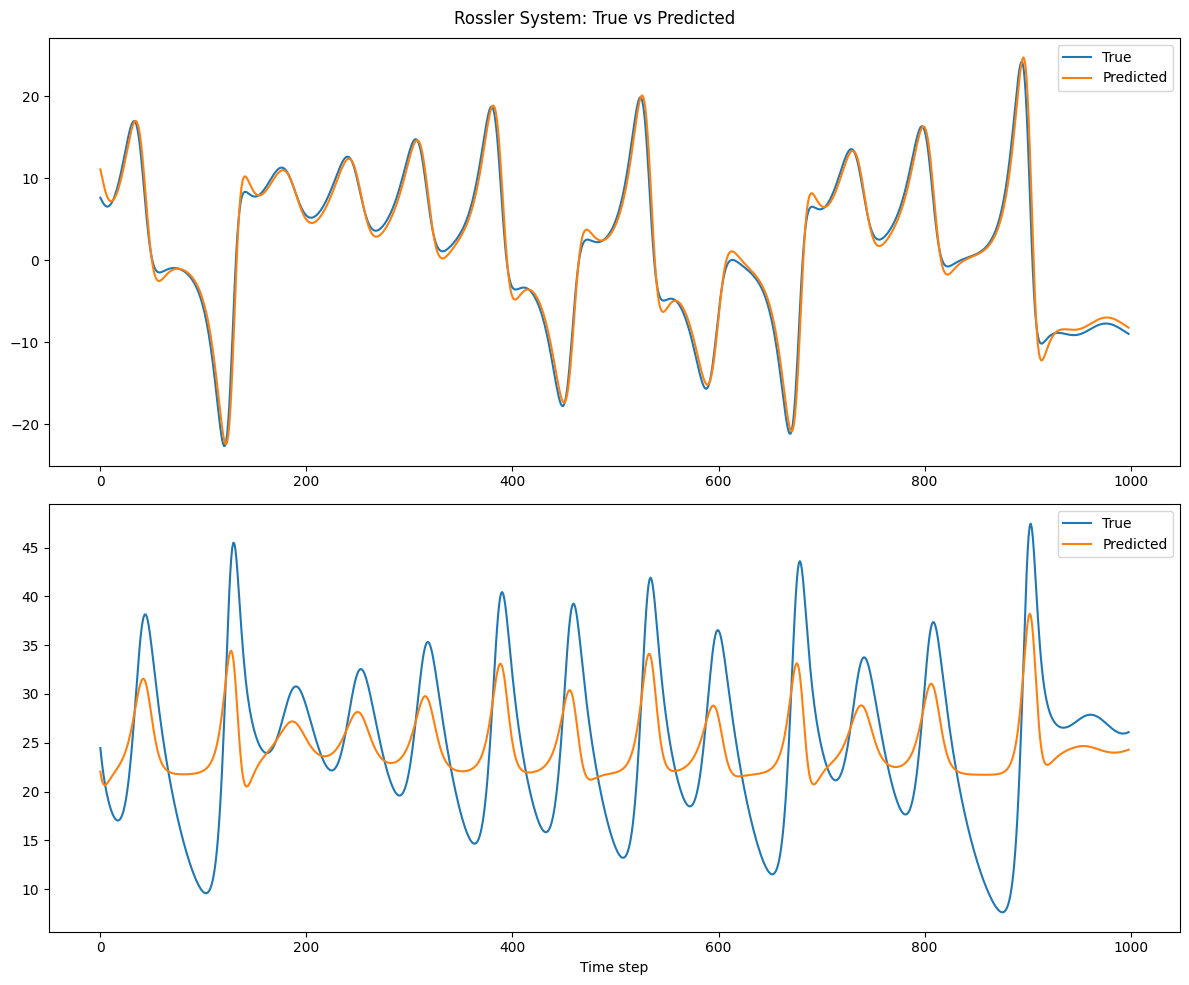

In [915]:
lorenz_predictions = lorenz_obs.predict(U, l_U_mean, l_U_val, l_Y_mean, l_Y_var)
print(lorenz_predictions.shape)
plot_results(Y_lor[:,2:], lorenz_predictions[:,2:], 'Rossler') #we ignore the first two points because the r needs to warm up

___

### Lets recreate figure 6 from part B in the paper
Here we will use z to deduce x

In [916]:
def plot_results_squared(true_data, predicted_data, system_name):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    

    axs[0].plot(true_data[0], label='True')
    axs[0].plot(predicted_data[0], label='Predicted')
    axs[0].set_ylabel(f'Variable x')
    axs[0].legend()

    axs[1].plot(true_data[1], label='True ^2')
    axs[1].plot(predicted_data[1], label='Predicted ^2')
    axs[1].set_ylabel(f'Variable x^2')
    axs[1].legend()
    
    plt.xlabel('Time step')
    plt.suptitle(f'{system_name} System: True vs Predicted')
    plt.tight_layout()
    plt.show()

In [917]:
U = np.reshape(lorenz_data[2,:],(1,-1)) #this is the continouesly avalable data. We will use the first coordinate. 
Y_lor = lorenz_data[:2] #this is what we will try to deduce. the other two coordinates 

print(f'Confirm that the shapes are good: \n{U.shape}')
print(Y_lor.shape)

M = U.shape[0] 
P = Y_lor.shape[0]

lorenz_obs = ReservoirObs(M=M, P=P, reservoir_num=400)
l_U_mean, l_U_val, l_Y_mean, l_Y_var = lorenz_obs.train(U, Y_lor)

Confirm that the shapes are good: 
(1, 1001)
(2, 1001)


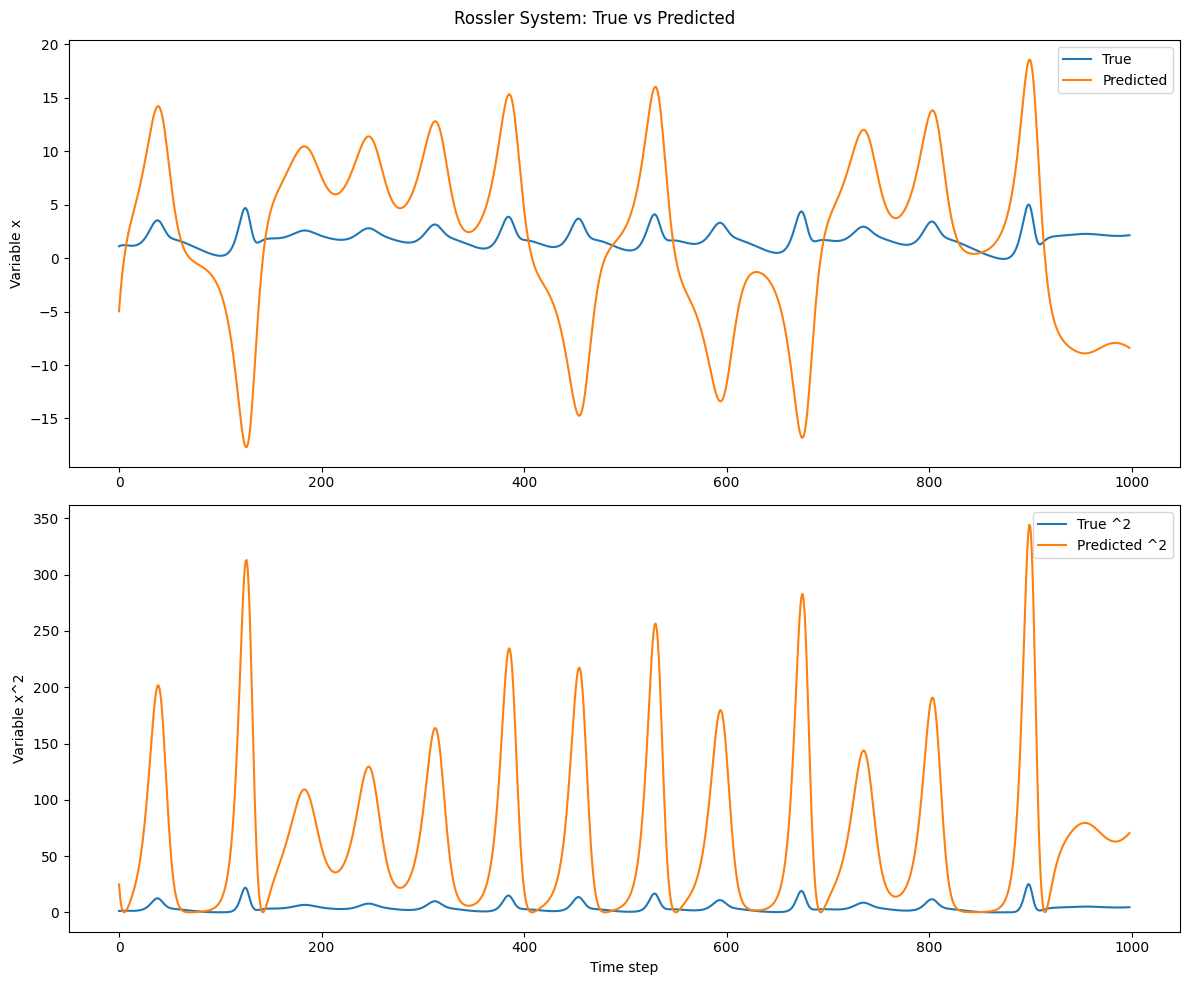

In [918]:
lorenz_predictions = lorenz_obs.predict(U, l_U_mean, l_U_val, l_Y_mean, l_Y_var)
lorenz_predictions_squared = np.reshape(lorenz_predictions[0] * lorenz_predictions[0], (1,-1))[:,2:]
lorenz_predictions = np.reshape(lorenz_predictions[0], (1,-1))[:,2:]


Y_lor_squared = np.reshape(Y_lor[0] * Y_lor[0], (1,-1))[:,2:]
Y_lor = np.reshape(Y_lor[0], (1,-1))[:,2:]

true_data = np.vstack((lorenz_predictions, lorenz_predictions_squared))
pred_data = np.vstack((Y_lor, Y_lor_squared))

plot_results_squared(true_data, pred_data, 'Rossler') #we ignore the first two points because the r needs to warm up

In [919]:
pred_data[1].shape

(999,)

In [920]:
rmse_x = rmse(true_data[0], pred_data[0])
rmse_xsquared = rmse(true_data[1], pred_data[1])
print(f'RMSE of the x is:{rmse_x}\nRMSE of the x^2 is :{rmse_xsquared}')

RMSE of the x is:7.9244770636092055
RMSE of the x^2 is :91.68868616456123


___

### Lets recreate figure 7 from part B in the paper
Now we predict x and y from z but modify the equation

In [921]:
#lets modify the equations 
# add x(t) to the third equation
def lorenz_modified(x, y, z, a=10, b=28, c=8/3):
    dxdt = -a*x + a*y
    dydt = b*x-y-x*z
    dzdt = x*y - c*z + dxdt
    return dxdt, dydt, dzdt

In [922]:
#genorate the data again
# Make the data
lorenz_initial = [-8, 8, 27]  # Changed initial conditions
lorenz_dt = 0.01  # Increased time step
lorenz_steps = 1000  # Increased number of steps
lorenz_data = euler_method(lorenz_modified, lorenz_initial, lorenz_dt, lorenz_steps).T

print(rossler_data.shape)


U = np.reshape(lorenz_data[2,:],(1,-1)) #this is the continouesly avalable data. We will use the first coordinate. 
Y_lor = lorenz_data[:2] #this is what we will try to deduce. the other two coordinates 

print(f'Confirm that the shapes are good: \n{U.shape}')
print(Y_lor.shape)

M = U.shape[0] 
P = Y_lor.shape[0]

lorenz_obs = ReservoirObs(M=M, P=P, reservoir_num=400)
l_U_mean, l_U_val, l_Y_mean, l_Y_var = lorenz_obs.train(U, Y_lor)

(3, 1001)
Confirm that the shapes are good: 
(1, 1001)
(2, 1001)


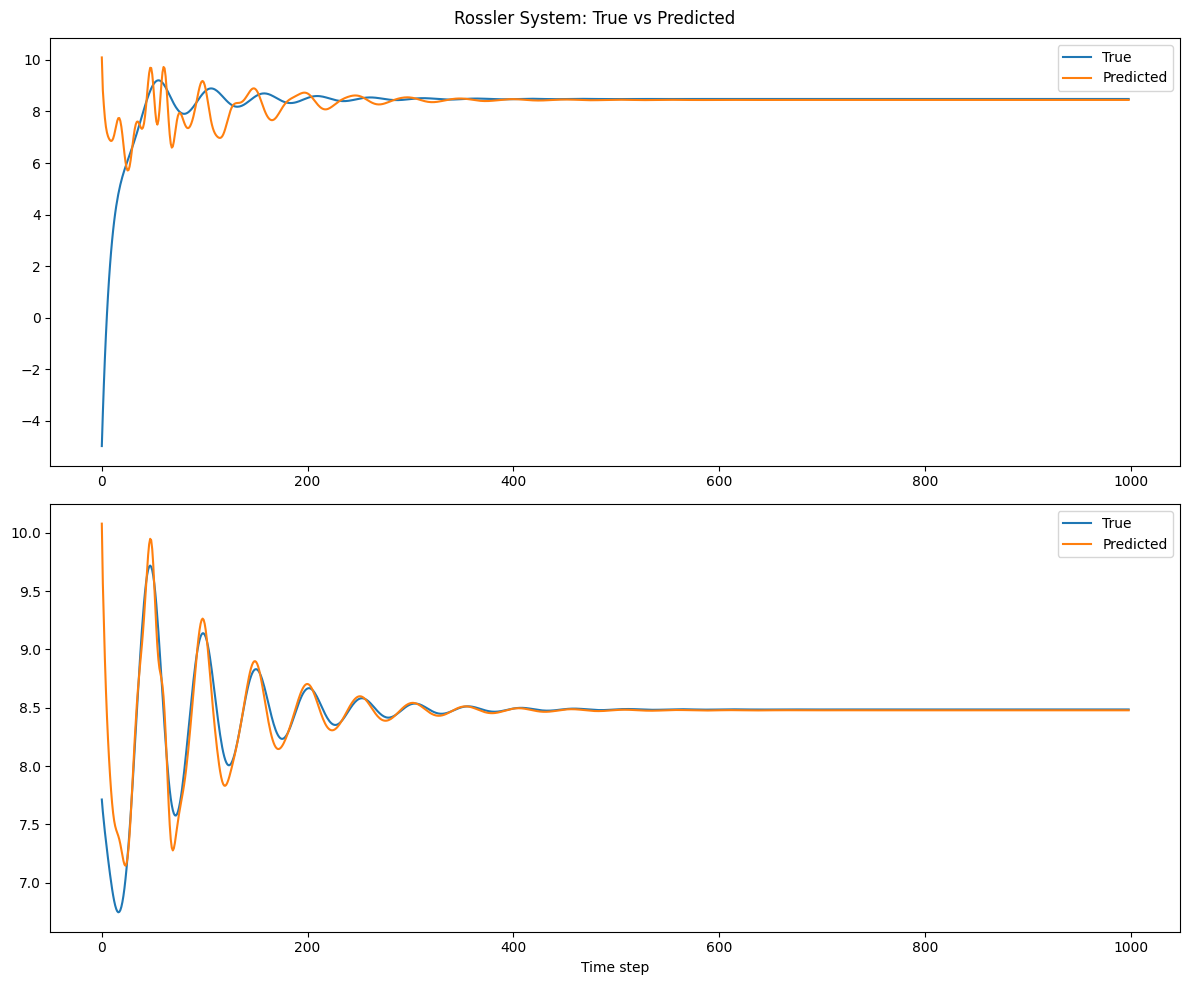

In [923]:
lorenz_predictions = lorenz_obs.predict(U, l_U_mean, l_U_val, l_Y_mean, l_Y_var)
plot_results(Y_lor[:,2:], lorenz_predictions[:,2:], 'Rossler') #we ignore the first two points because the r needs to warm up

___